### **Import Libraries**

In [470]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.stem import PorterStemmer
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

### **Data Loading**

In [489]:
df = pd.read_csv('data.txt', delimiter='\t', header=None, names=['label', 'text'])
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### **Data Preprocessing**

**Remove duplicate values**

In [472]:
df = df.drop_duplicates(keep='first')

**Split into Independent and dependent variable**

In [473]:
x = df['text']
y = df['label']

**Text Preprocessing**

Creating a function to:
- lowercase the text
- remove special characters
- normalize certain words use stems of words instead of the original form using porter stemmer algorithm

In [474]:
porter_stemmer = PorterStemmer()
def preprocessor(text):
    text = text.lower()
    text = re.sub("\\W", " ", text)
    text = re.sub("\\s+(in|the|all|for|and|on)\\s+", " _connector_ ", text)
    words = re.split("\\s+", text)
    stemmed_words = [porter_stemmer.stem(word=word) for word in words]
    return ' '.join(stemmed_words)

Creating tokenizer function to create a space between special characters, split based on whitespace

In [475]:
def tokenizer(text):
    text = re.sub("(\\W)", " \\1 ", text)
    return re.split("\\s+", text)

**Feature extraction**

In [476]:
vectorizer = CountVectorizer(tokenizer=tokenizer, ngram_range=(1,2), min_df=0.006, preprocessor=preprocessor)
x = vectorizer.fit_transform(x)
print(x)

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 63107 stored elements and shape (5169, 515)>
  Coords	Values
  (0, 149)	1
  (0, 332)	1
  (0, 314)	1
  (0, 16)	1
  (0, 286)	1
  (0, 155)	1
  (0, 128)	1
  (0, 404)	1
  (0, 154)	1
  (0, 455)	1
  (0, 0)	1
  (1, 0)	1
  (1, 309)	1
  (1, 230)	1
  (1, 434)	1
  (2, 16)	1
  (2, 141)	1
  (2, 8)	1
  (2, 28)	1
  (2, 413)	3
  (2, 476)	1
  (2, 261)	1
  (2, 393)	1
  (2, 346)	1
  (2, 433)	1
  :	:
  (5166, 45)	1
  (5166, 316)	1
  (5167, 16)	3
  (5167, 141)	1
  (5167, 413)	1
  (5167, 190)	2
  (5167, 172)	1
  (5167, 217)	1
  (5167, 461)	1
  (5167, 105)	1
  (5167, 240)	1
  (5167, 373)	1
  (5167, 61)	1
  (5167, 401)	1
  (5167, 293)	1
  (5167, 112)	1
  (5167, 443)	1
  (5167, 73)	1
  (5167, 375)	1
  (5167, 75)	1
  (5167, 74)	1
  (5167, 161)	1
  (5168, 413)	1
  (5168, 217)	2
  (5168, 287)	1


**Check Data is imbalanced**

<Axes: xlabel='count', ylabel='label'>

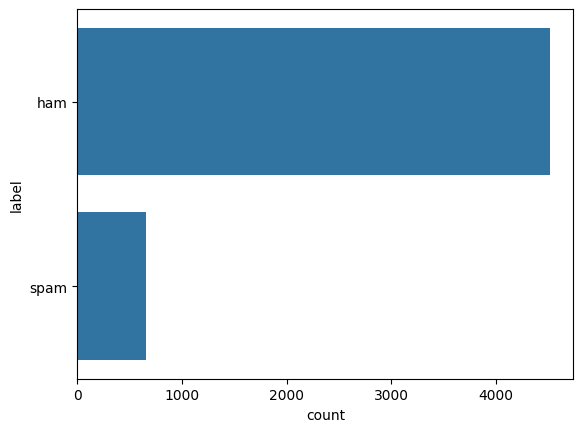

In [477]:
sns.countplot(df['label'])

Target class has an uneven distribution of observations, so using random over sampling method to balance the target variable’s observation

In [478]:
ran = RandomOverSampler(random_state=42)
print(f'Original dataset shape : {Counter(y)}')

x, y = ran.fit_resample(x, y)
print(f'Modified dataset shape : {Counter(y)}')

Original dataset shape : Counter({'ham': 4516, 'spam': 653})
Modified dataset shape : Counter({'ham': 4516, 'spam': 4516})


### **Data Spliting**

In [479]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

### **Model Training and Testing**

**Naive Bayes Model**

In [480]:
nb = MultinomialNB()
nb.fit(x_train,y_train)
accuracy = accuracy_score(y_test, nb.predict(x_test))
accuracy

0.9629219701162147

**SVM Model**

In [481]:
model = SVC(C=1, kernel="linear")
model.fit(x_train, y_train)
accuracy = accuracy_score(y_test, model.predict(x_test))
accuracy

0.9905921416712784

### **Hyperparameter Optimization**

**Naive Bayes Model**

In [482]:
params = {
    'alpha': [0.1, 0.5, 1.0],
    'fit_prior': [True, False]
}

cval = KFold(n_splits=2)
model = MultinomialNB()
tunedNB = GridSearchCV(model, params, cv=cval)
tunedNB.fit(x_train, y_train)

accuracy = accuracy_score(y_test, tunedNB.predict(x_test))
accuracy

0.9640287769784173

**SVM Model**

In [483]:
params = {"C": [0.2, 0.5], "kernel": ['linear', 'sigmoid']}

cval = KFold(n_splits=2)
model =  SVC();
tunedSVM = GridSearchCV(model, params, cv=cval)
tunedSVM.fit(x_train, y_train)

accuracy = accuracy_score(y_test, tunedSVM.predict(x_test))
accuracy

0.9889319313779745

### **Model Evaluation**

**Confusion matrix**

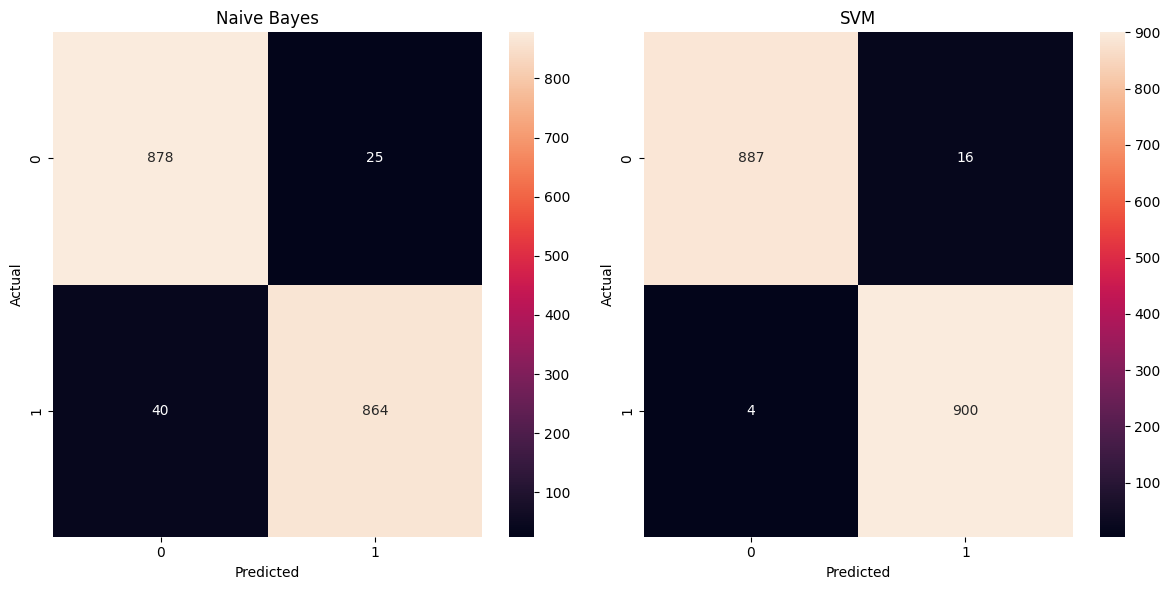

In [484]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(confusion_matrix(y_test, tunedNB.predict(x_test)), annot=True, fmt="g", ax=axes[0])
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
axes[0].set_title("Naive Bayes")

sns.heatmap(confusion_matrix(y_test, tunedSVM.predict(x_test)), annot=True, fmt="g", ax=axes[1])
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")
axes[1].set_title("SVM")

plt.tight_layout()
plt.show()

**Classification report**

In [485]:
print(classification_report(y_test,tunedNB.predict(x_test)))

              precision    recall  f1-score   support

         ham       0.96      0.97      0.96       903
        spam       0.97      0.96      0.96       904

    accuracy                           0.96      1807
   macro avg       0.96      0.96      0.96      1807
weighted avg       0.96      0.96      0.96      1807



In [486]:
print(classification_report(y_test,tunedSVM.predict(x_test)))

              precision    recall  f1-score   support

         ham       1.00      0.98      0.99       903
        spam       0.98      1.00      0.99       904

    accuracy                           0.99      1807
   macro avg       0.99      0.99      0.99      1807
weighted avg       0.99      0.99      0.99      1807



### **Model Saving**

In [487]:
joblib.dump(tunedSVM, 'model.pkl')

['model.pkl']